In [14]:
import torch
import os
import gzip
import pickle
import time
import numpy as np 
import tensorflow as tf

## Load and examine dataset

In [15]:
""" Load the dataset
Code adapted from http://deeplearning.net/tutorial/code/logistic_sgd.py

:type dataset: string
:param dataset: the path to the dataset (here MNIST)
"""
# Download the MNIST dataset if it is not present
dataset = "mnist.pkl.gz"

data_dir, data_file = os.path.split(dataset)
if data_dir == "" and not os.path.isfile(dataset):
    # Check if dataset is in the data directory.
    new_path = os.path.join(
        os.path.split(__file__)[0],
        dataset
    )
    if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
        dataset = new_path

if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
    from six.moves import urllib
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

print('Loading data...')

# Load the dataset
with gzip.open(dataset, 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)

print('Loaded train_set, valid_set and test_set.')

Loading data...
Loaded train_set, valid_set and test_set.


In [16]:
print(train_set[0].shape)
print(train_set[1].shape)

# because we use lenet, we need to reshape the data to [batch, height, width, channel]
train_set = (train_set[0].reshape((-1, 28, 28, 1)), train_set[1])
valid_set = (valid_set[0].reshape((-1, 28, 28, 1)), valid_set[1])
test_set = (test_set[0].reshape((-1, 28, 28, 1)), test_set[1])

print(train_set[0].shape)
print(train_set[1].shape)

(50000, 784)
(50000,)
(50000, 28, 28, 1)
(50000,)


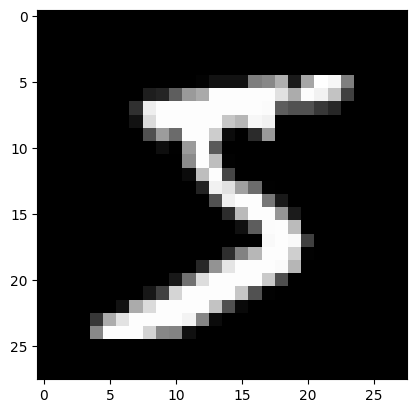

In [17]:
# plot a random sample
import matplotlib.pyplot as plt
plt.imshow(train_set[0][:][:][0], cmap='gray')
plt.show()

In [18]:
batch_size = 64

train_set = (train_set[0].astype('float32'), train_set[1].astype('int64'))
valid_set = (valid_set[0].astype('float32'), valid_set[1].astype('int64'))
test_set = (test_set[0].astype('float32'), test_set[1].astype('int64'))

train_dataset = tf.data.Dataset.from_tensor_slices(train_set)
train_loader = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_set)
valid_loader = valid_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_set)
test_loader = test_dataset.batch(batch_size)


In [19]:
model = tf.keras.models.Sequential([
    # conv2d -> relu -> maxpool -> bn
    tf.keras.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(6, 5, activation='relu', use_bias=False),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.BatchNormalization(),

    # conv2d -> relu -> maxpool -> bn
    tf.keras.layers.Conv2D(16, 5, activation='relu', use_bias=False),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.BatchNormalization(),

    # flatten -> affine -> relu
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),

    # affine
    tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(0.05),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    train_loader,
    epochs=10,
    validation_data=valid_loader,
)

Epoch 1/10


2023-04-30 15:08:13.518326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [50000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-04-30 15:08:13.518643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [50000]
	 [[{{node Placeholder/_1}}]]


779/782 [============================>.] - ETA: 0s - loss: 0.1919 - sparse_categorical_accuracy: 0.9429

2023-04-30 15:08:27.890981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [10000]
	 [[{{node Placeholder/_1}}]]


782/782 [==============================] - 16s 20ms/step - loss: 0.1916 - sparse_categorical_accuracy: 0.9430 - val_loss: 0.1076 - val_sparse_categorical_accuracy: 0.9632
Epoch 2/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.1169 - val_sparse_categorical_accuracy: 0.9632
Epoch 3/10
782/782 [==============================] - 12s 16ms/step - loss: 0.0443 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0495 - val_sparse_categorical_accuracy: 0.9857
Epoch 4/10
782/782 [==============================] - 14s 18ms/step - loss: 0.0345 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.0859 - val_sparse_categorical_accuracy: 0.9734
Epoch 5/10
782/782 [==============================] - 14s 18ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.0440 - val_sparse_categorical_accuracy: 0.9872
Epoch 6/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0237 - sparse_categoric

In [20]:
import json

# save the results: train_loss_list, train_acc_list, valid_acc_list

train_loss_list = model.history.history['loss']
train_acc_list = model.history.history['sparse_categorical_accuracy']
valid_acc_list = model.history.history['val_sparse_categorical_accuracy']

with open("results/tensorflow_lenet.json", "w") as f:
    json.dump({
        "train_loss": train_loss_list,
        "train_acc": train_acc_list,
        "valid_acc": valid_acc_list
    }, f)